<a href="https://colab.research.google.com/github/lijingwang/IntroSpatialData_SDSI/blob/main/Introduction_to_spatial_data_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Author: Lijing Wang, lijing52@stanford.edu, 2022


---






Geographic data is used everywhere. From ordering food online to understanding where food grows, from looking up weather for today, to analyzing climate risks in the future, a lot of data is geographically located. In fact, some estimates suggest as much as [80% of big data could be geographic](https://www.tandfonline.com/doi/full/10.1080/10095020.2020.1754138). In this article, we will learn to use and analyze geographic data with the following objectives in mind:

**Expected learning outcomes**:   

1.   We will learn how to visualize a spatial point dataset on a map
2.   We will analyze the spatial correlation using variogram
3.   We will learn how to interpolate the missing spatial data
4.   We will learn how to estimate uncertainty of interpolated spatial data



Because data can be mapped based on any reference (e.g., surface of Earth, or corners of a room), we will use the term "spatial data" instead of geographic data hence forth. But think of spatial data as the same thing: any measurement which is associated with a location.

# Examples of spatial datasets

Let's first take a look at different real world spatial datasets: 






## *Social Science*: Safety alert map of San Francisco Bay Area 

Credit: [Citizen](https://citizen.com/), Date: 01/12/2022




![safety_bayarea.jpg](https://drive.google.com/uc?export=view&id=1Su_tu7BgxhxuSqPWLXz_2UnTgoUOU9cI)


This is a safety alert map of San Francisco Bay Area from the [Citizen](https://citizen.com/) app. Each incident is labeled with the geo-reference coordinates. The radius indicates the severeness of that event. 

This example shows us one common type of spatial data: *point data*. Point data is not associated with any spatial resolution. Each data point just represents one event or one measurement. 


## *Epidemology*: Covid-19 Hospitalization map of the U.S. 

Credit: [The New York Times](https://www.nytimes.com/interactive/2021/us/covid-cases.html), Date: 01/12/2022



![covid_hospitalization.jpg](https://drive.google.com/uc?export=view&id=1qpO1feDai120ShdnqpxPS_vdhI87BmE7)

Another example is the COVID hospitalization map. The color of each county indicates how many patients have been hospitalized per 100,000 people. Instead of being a point-wise dataset, now the spatial data is represented by *polygons*, where we take some average within one polygon. Then the spatial resolution of each data is determined by the area of each county. 

We do see some gray polygons with no data because some counties do not share the hospitalization rate publicly. In spatial data analysis, we often have this missing data problem. Therefore, we want to know if we can do some interpolations to fill-in those missing locations. 

For example, if we want to interpolate the missing data in one county of Oregon and in one county of Ohio, can we guess which one has a higher hospitalization rate? Possibly Ohio, right? Because the available counties in Ohio have higher hospitalization rates than in Oregon. This can be quantitively termed as *spatial correlation*. We will see a hands-on example of this in the next section.



## *Earth science*: Groundwater level in California


Groundwater makes up 40% to 60 % of the entire California water supply, including city and agriculture use. Especially in Central Valley, which is one of the most productive agricultural regions in the world, many farmers rely exclusively on groundwater to irrigate their lands during dry years. Overdrafting the groundwater results in land subsidence and even deplete groundwater storage permanently. 







![land_subsidence.jpg](https://drive.google.com/uc?export=view&id=1CTY_vJ-8CeLCFlsPvOzQJ2F1rZpBM1n3)

San Joaquin Valley, southwest of Mendota, California. Signs on pole show approximate altitude of land surface in 1925, 1955, and 1977. The land surface subsided about 9 meters from 1925 to 1977 due to overdrafting.


Source: Dr. Joseph F. Poland, USGS

# Visualizing spatial point data


California has been actively monitoring groundwater levels for many years. In this example, we will use groundwater level measurements last fall (Fall 2021) in Central Valley, and do spatial interpolation using spatial statistics/geostatistics. 

Data source: [California natural resources agency](https://data.cnra.ca.gov/dataset/periodic-groundwater-level-measurements)


Let's load the point-wise groundwater elevation measurements:

In [1]:
# load the necessary module
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import warnings
import seaborn as sns
import plotly.express as px
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon

warnings.filterwarnings("ignore") # Please uncomment this line and see your warnings if you use this code further for your research

In [2]:
# Clone data from our GitHub repository
! git clone https://github.com/lijingwang/IntroSpatialData_SDSI.git

Cloning into 'IntroSpatialData_SDSI'...
remote: Enumerating objects: 19, done.
remote: Counting objects: 100% (19/19), done.
remote: Compressing objects: 100% (13/13), done.
remote: Total 19 (delta 2), reused 13 (delta 2), pack-reused 0
Unpacking objects: 100% (19/19), done.


In [3]:
# Load data
## California groundwater elevation during 2021 fall (Sep - Nov)
groundwater = pd.read_csv('/content/IntroSpatialData_SDSI/Data/california_groundwater_level_2021_fall.csv')
## Central Valley polygon
central_valley_polygon = pd.read_csv('/content/IntroSpatialData_SDSI/Data/CV_bounds.csv')

Groundwater level in California, Sep - Nov 2021

In [4]:
fig = px.scatter_mapbox(groundwater, lat="LATITUDE", lon="LONGITUDE", color = 'GWE',hover_data=["GWE"],
                        color_discrete_sequence=["fuchsia"], zoom=5, height=800)
                        
fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.layout.coloraxis.colorbar.title = 'Groundwater level (feet)' # above mean sea level
fig.show()

Let's zoom into the groundwater level data within the central valley:

In [5]:
# Within central valley polygon
central_valley = Polygon(central_valley_polygon.values)
point_sets = [Point((groundwater['LONGITUDE'][i],groundwater['LATITUDE'][i])) for i in range(len(groundwater))]
in_valley_or_not = [central_valley.contains(point) for point in point_sets]
groundwater = groundwater[in_valley_or_not]

In [6]:
fig = px.scatter_mapbox(groundwater, lat="LATITUDE", lon="LONGITUDE", color = 'GWE',hover_data=["GWE"],
                        color_discrete_sequence=["fuchsia"], zoom=6, height=800)           
fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.layout.coloraxis.colorbar.title = 'Groundwater level (feet)'    
fig.show()

We do see the spatial correlation of those point measurements, where the nearby points share similar values. In the next section, we will understand this spatial correlation quantitatively. 

# Spatial correlation: variogram analysis

## Empirical variogram

In [7]:
! pip install geostatspy
! pip install pyproj

     |████████████████████████████████| 57 kB 1.5 MB/s 
     |████████████████████████████████| 6.3 MB 5.8 MB/s 


In [8]:
import geostatspy.geostats as geostats
from pyproj import Proj

# Project data from lat, lon to utm coordinates
p = Proj(proj='utm',zone=10,ellps='WGS84', preserve_units=False)

# UTM polygon
cv_x,cv_y = p(central_valley_polygon.values[:,0],central_valley_polygon.values[:,1])
cv_x = cv_x/1000
cv_y = cv_y/1000
central_valley_xy = Polygon(np.array([cv_x,cv_y]).T)

# UTM groundwater elevation
## UTM (meters)
groundwater['x'],groundwater['y'] = p(groundwater['LONGITUDE'].values, groundwater['LATITUDE'].values)

## UTM (km)
groundwater['x'] = groundwater['x']/1000.
groundwater['y'] = groundwater['y']/1000.

Start from any point data and make it as a center of a circle, groundwater levels are quite different if we move outside circle with radius ~80km. We call this 80km as the correlation length, or in geostatistics, the range. 

Text(0.5, 1.0, 'Groundwater level (feet)')

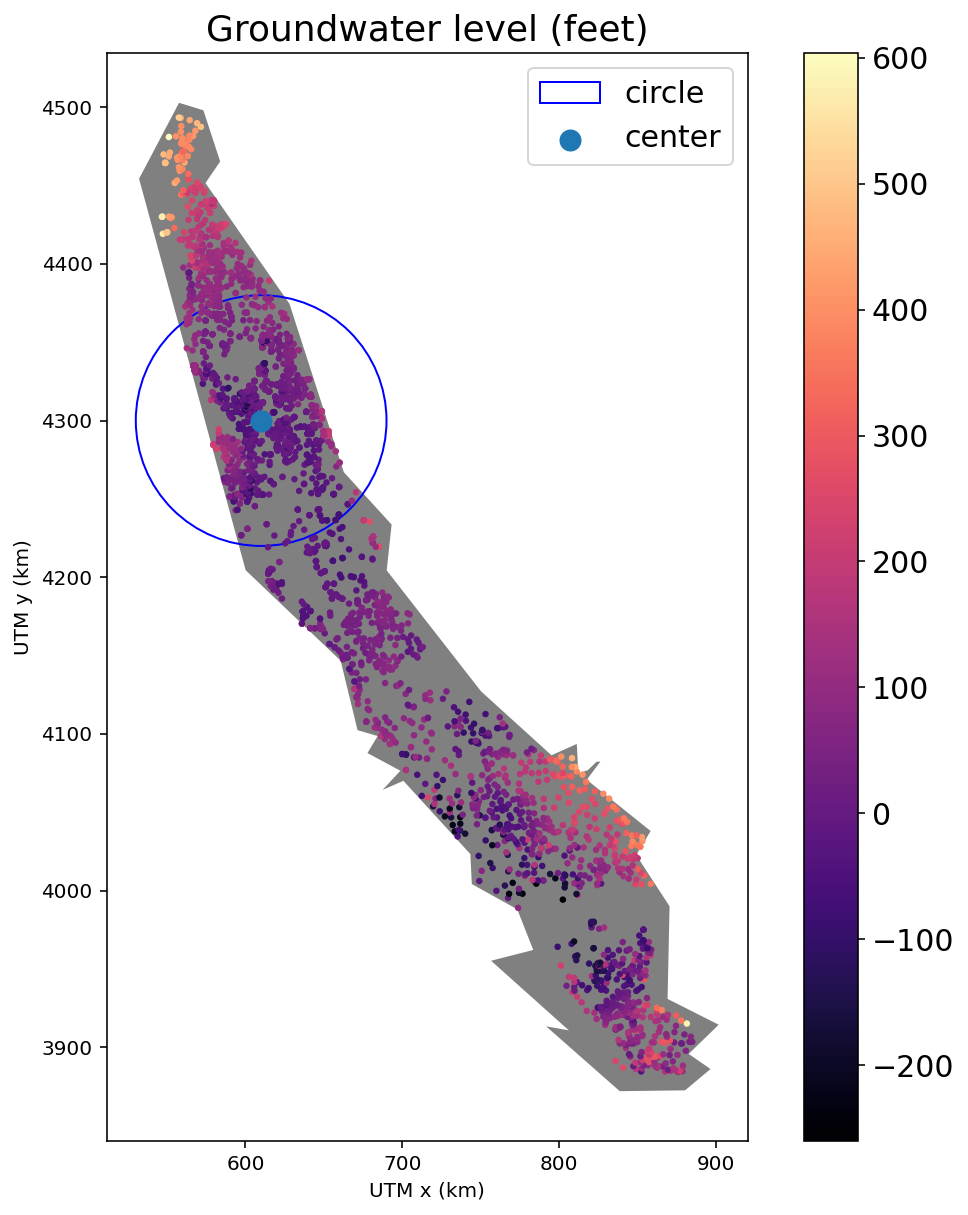

In [9]:
import matplotlib.patches as patches
fig, ax = plt.subplots(figsize=[10,10])
matplotlib.rcParams.update({'font.size': 15})

patch = patches.Polygon(np.array([cv_x,cv_y]).T,fc = 'gray')
ax.add_patch(patch)
plt.scatter(groundwater['x'],groundwater['y'],c = groundwater['GWE'],s = 5,cmap = 'magma',zorder = 1000)
plt.colorbar()
plt.scatter(610, 4300,s = 100,zorder = 10000,label = 'center')
circle = plt.Circle((610, 4300), 80, color='b', fill=False,label = 'circle')
ax.add_patch(circle)
plt.gca().set(aspect='equal')
plt.xlabel('UTM x (km)')
plt.ylabel('UTM y (km)')
plt.legend()
plt.title('Groundwater level (feet)')

Let's denote the spatial location as $x$, the groundwater level as a function of spatial location $Z(x)$. We can study the pairwise difference with the distance $h$. We collect all possible pairs with location $x_i+h$ and $x_i$ (the below figure shows two pairs but there are more!) and calculate the difference between two groundwater levels: 

$$(Z(x_i+h)-Z(x_i))^2, i = 1, 2, ..., N(h)$$

Text(0.5, 1.0, 'Groundwater level (feet)')

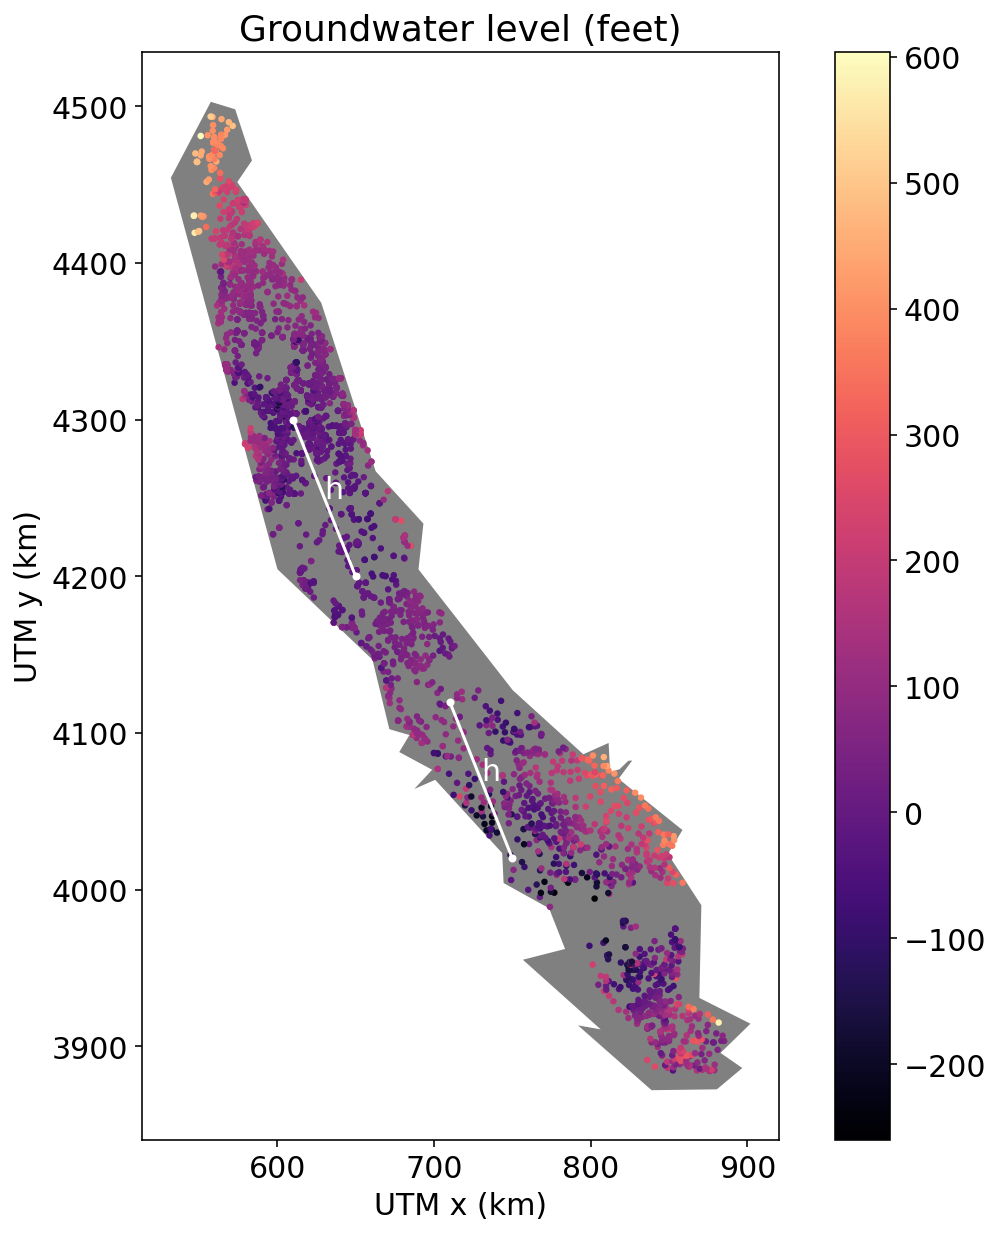

In [10]:
fig, ax = plt.subplots(figsize=[10,10])

patch = patches.Polygon(np.array([cv_x,cv_y]).T,fc = 'gray')
ax.add_patch(patch)
plt.scatter(groundwater['x'],groundwater['y'],c = groundwater['GWE'],s = 5,cmap = 'magma',zorder = 1000)
plt.colorbar()
plt.plot([610,650], [4300,4200],'.',zorder = 10000,color = 'white')
plt.plot([610,650], [4300,4200],zorder = 10000,color = 'white')
plt.plot([710,750], [4120,4020],'.',zorder = 10000,color = 'white')
plt.plot([710,750], [4120,4020],zorder = 10000,color = 'white')
plt.text(630,4250,'h',color = 'white',zorder = 10000)
plt.text(730,4070,'h',color = 'white',zorder = 10000)
plt.gca().set(aspect='equal')
plt.xlabel('UTM x (km)')
plt.ylabel('UTM y (km)')
plt.title('Groundwater level (feet)')

Then for each distance $h$, we can define a parameter $\gamma(h)$ to average all possible differences: 
$$\gamma(h) = \frac{1}{2N(h)}∑_{i = 1}^{N(h)} (Z(x_i+h)-Z(x_i))^2$$

which is called the *variogram* (semi-variogram in this case because the right hand side is divided by two). 

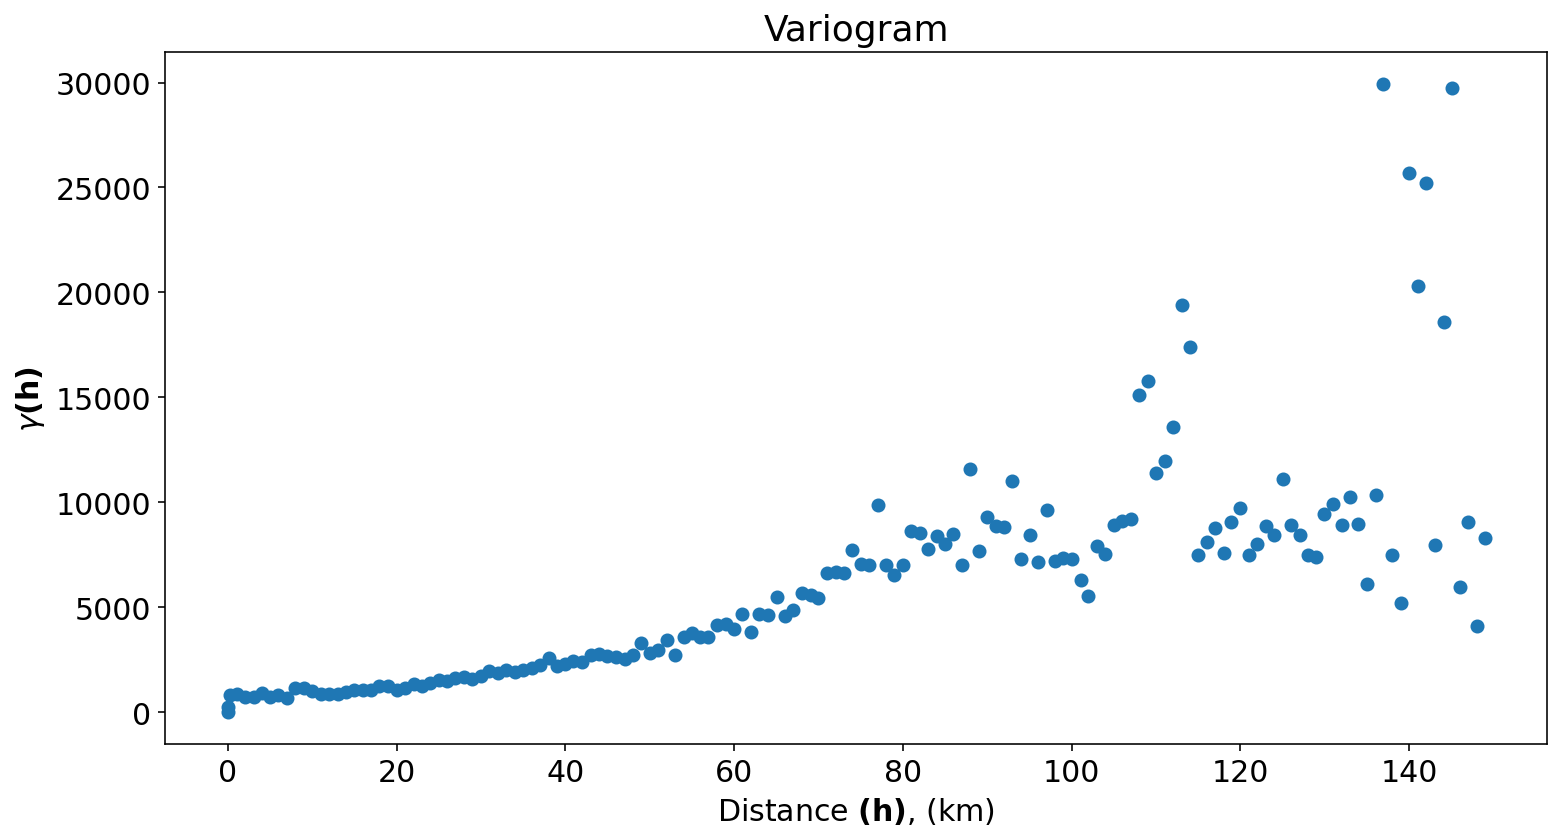

In [11]:
# Variogram calculation

tmin = -9999.; tmax = 9999.;  # limits
lag_dist = 1.0 # lag distance interval (in km)
lag_tol = 0.5 # lag tolerance
nlag = 150 # number of lag distances to use
bandh = 10 # no effect for isotropic variogram
azi = 0 # azimuth
atol = 90.0 # azimuth tolerance. If atol = 90, the isotropic variogram is calculated
isill = 0 # no effect for normal score transformed data

# compute isotropic variogram
lag, gamma, npair = geostats.gamv(groundwater,'x','y','GWE',
                                  tmin,tmax,lag_dist,lag_tol,nlag,azi,atol,bandh,isill)

# plot variogram
plt.figure(figsize = [8,4])
plt.scatter(lag,gamma)
plt.xlabel(r'Distance $\bf(h)$, (km)')
plt.ylabel(r'$\gamma \bf(h)$')
plt.title('Variogram')

plt.subplots_adjust(left=0.0, bottom=0.0, right=1.2, top=1.2, wspace=0.1, hspace=0.2) # adjust the plot size
plt.show()



We plot $h$ on x-axis, $\gamma(h)$ on y-axis. This variogram plot tells us two spatial data are not that different if they are close to each other (because $\gamma(h)$ is low for low values of $h$). Two spatial data are quite different if they are far away ($h$ > 80 km). This plot levels off when $h$ > 80 km. We have two new terms to describe this variogram: 


*   Range: distance $h$ where the variogram levels off
*   Sill: the level off value $\gamma (h)$





We have calculated variogram empirically to quantify the spatial correlation.  Next we would like to fit this variogram using statistical models and make interpolations for the missing locations.  

## Three variogram models

There are three common types of variogram models: 

*   Exponential type: 1-exp(-$h$)
*   Spherical type: 1.5$h$-0.5$h^3$
*   Gaussian type: 1-exp(-$h^2$)

Here I present three types of variograms with the same range = 5, the same sill = 1. These models are quite different when $h$ is small. Gaussian has the smoothest transition.  



In [12]:
import sys
sys.path.append('/content/IntroSpatialData_SDSI/code/')
import geostats_tools as gs

In [13]:
Azimuth = 0 # azimuthal direction of major axis
nug = 0 # nugget
nstruct = 1 # variogram structures
vtype = [1] # exponential type (1 = spherical, 2 = exponential, 3 = Gaussian)
cc = [1] # contribution for each structure. nugget + cc = 1
a = [5] 
x = np.linspace(0,10,100)

exp_model = gs.axis_var(x, 
                    nug, nstruct, cc, [2], a)
sph_model = gs.axis_var(x, 
                    nug, nstruct, cc, [1], a)
gau_model = gs.axis_var(x, 
                    nug, nstruct, cc, [3], a)

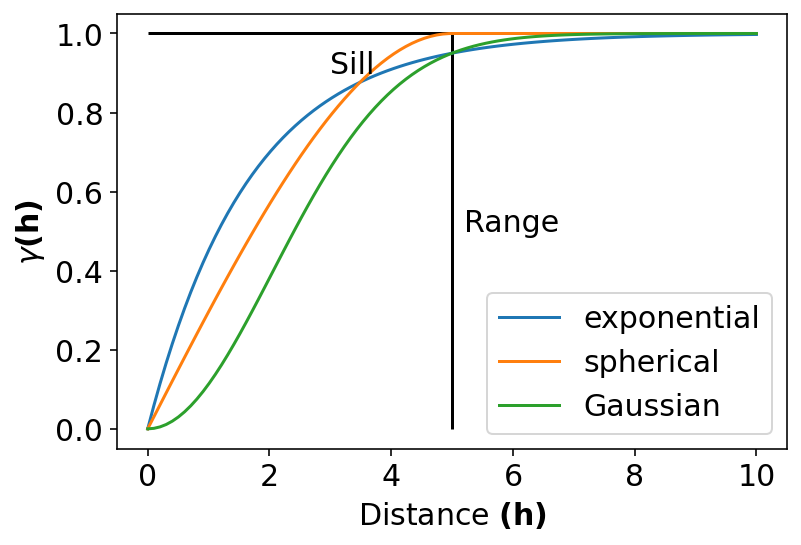

In [14]:
plt.plot(x,exp_model,label = 'exponential')
plt.plot(x,sph_model,label = 'spherical')
plt.plot(x,gau_model,label = 'Gaussian')
plt.vlines(x = 5,ymin = 0,ymax = 1)
plt.hlines(y = 1,xmin = 0,xmax = 10)
plt.text(5.2,0.5,'Range')
plt.text(3,0.9,'Sill')
plt.xlabel(r'Distance $\bf(h)$')
plt.ylabel(r'$\gamma \bf(h)$')
plt.legend()

Here are three synthetic spatial maps, with the same variogram parameters except the variogram types. We can see the different levels of smoothness clearly: Gaussian > Spherical > Exponential. 




![variogram_types.jpg](https://drive.google.com/uc?export=view&id=1CDrc3cgmrFB0o3o0MsDbAsH-rAGOHVJg)

# Spatial interpolation: kriging 

We will now use kriging to do the spatial interpolation. Kriging originates from the mining industry, where people wished to predict how gold is distributed in the subsurface. Kriging is also named as Gaussian Process regression, where we need to make the Gaussian assumption first. 

So before we fit the variogram model, we perform a normal score transformation (NST) to transfer our groundwater elevation data into a standard Gaussian distribution. Then, we will fit the variogram model on the transformed data. Later after we do the interpolation, we will transfer it back.


## Normal score transformation

The idea of the normal score transformation is: 

for each original data $x$, we want to find $y$ so that

$$P(X \leq x) = P(Y \leq y)$$

where $Y$ is a standard Gaussian variable.  

In [15]:
# Normal score transformation
groundwater['GWE_ns'],  tvgwe, tnsgwe  = geostats.nscore(groundwater,'GWE')

Text(0, 0.5, 'Empirical CDF: P(Y<=y)')

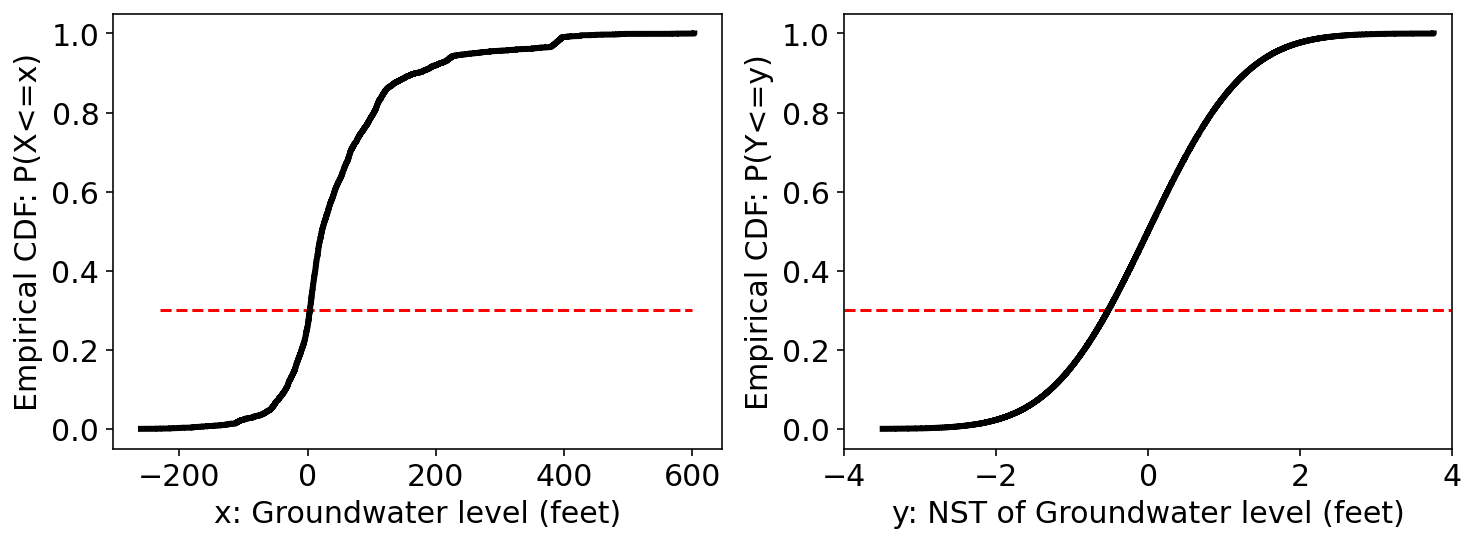

In [16]:
matplotlib.rc("figure", figsize=(12,4))
ax = plt.subplot(1, 2, 1)
plt.step(np.sort(groundwater['GWE']), (np.arange(len(groundwater['GWE']))+1)/len(groundwater['GWE']),linewidth = 3, color = 'black',where = 'post')
plt.hlines(y = 0.3,xmin = -230,xmax = 600,color = 'red',linestyles='--')
plt.xlabel('x: Groundwater level (feet)')
plt.ylabel('Empirical CDF: P(X<=x)')

ax = plt.subplot(1, 2, 2)
plt.step(np.sort(groundwater['GWE_ns']), (np.arange(len(groundwater['GWE']))+1)/len(groundwater['GWE']),linewidth = 3, color = 'black',where = 'post')
plt.xlim(-4,4)
plt.hlines(y = 0.3,xmin = -4,xmax = 4,color = 'red',linestyles='--')
plt.xlabel('y: NST of Groundwater level (feet)')
plt.ylabel('Empirical CDF: P(Y<=y)')

The figure shows when $x = 0$, $P(X\leq x) = 0.3$, then $P(Y\leq y) = 0.3$, $y = 0.5$.

## Fit the variogram

Here we pick sill = 1, range = 100km, and the spherical type for the variogram of the transformed data: 

In [17]:
# Variogram calculation

tmin = -9999.; tmax = 9999.;  # limits
lag_dist = 1.0 # lag distance interval (in km)
lag_tol = 0.5 # lag tolerance
nlag = 150 # number of lag distances to use
bandh = 10 # no effect for isotropic variogram
azi = 0 # azimuth
atol = 90.0 # azimuth tolerance. If atol = 90, the isotropic variogram is calculated
isill = 1 # no effect for normal score transformed data

# compute isotropic variogram
lag, gamma, npair = geostats.gamv(groundwater,'x','y','GWE_ns',
                                  tmin,tmax,lag_dist,lag_tol,nlag,azi,atol,bandh,isill)

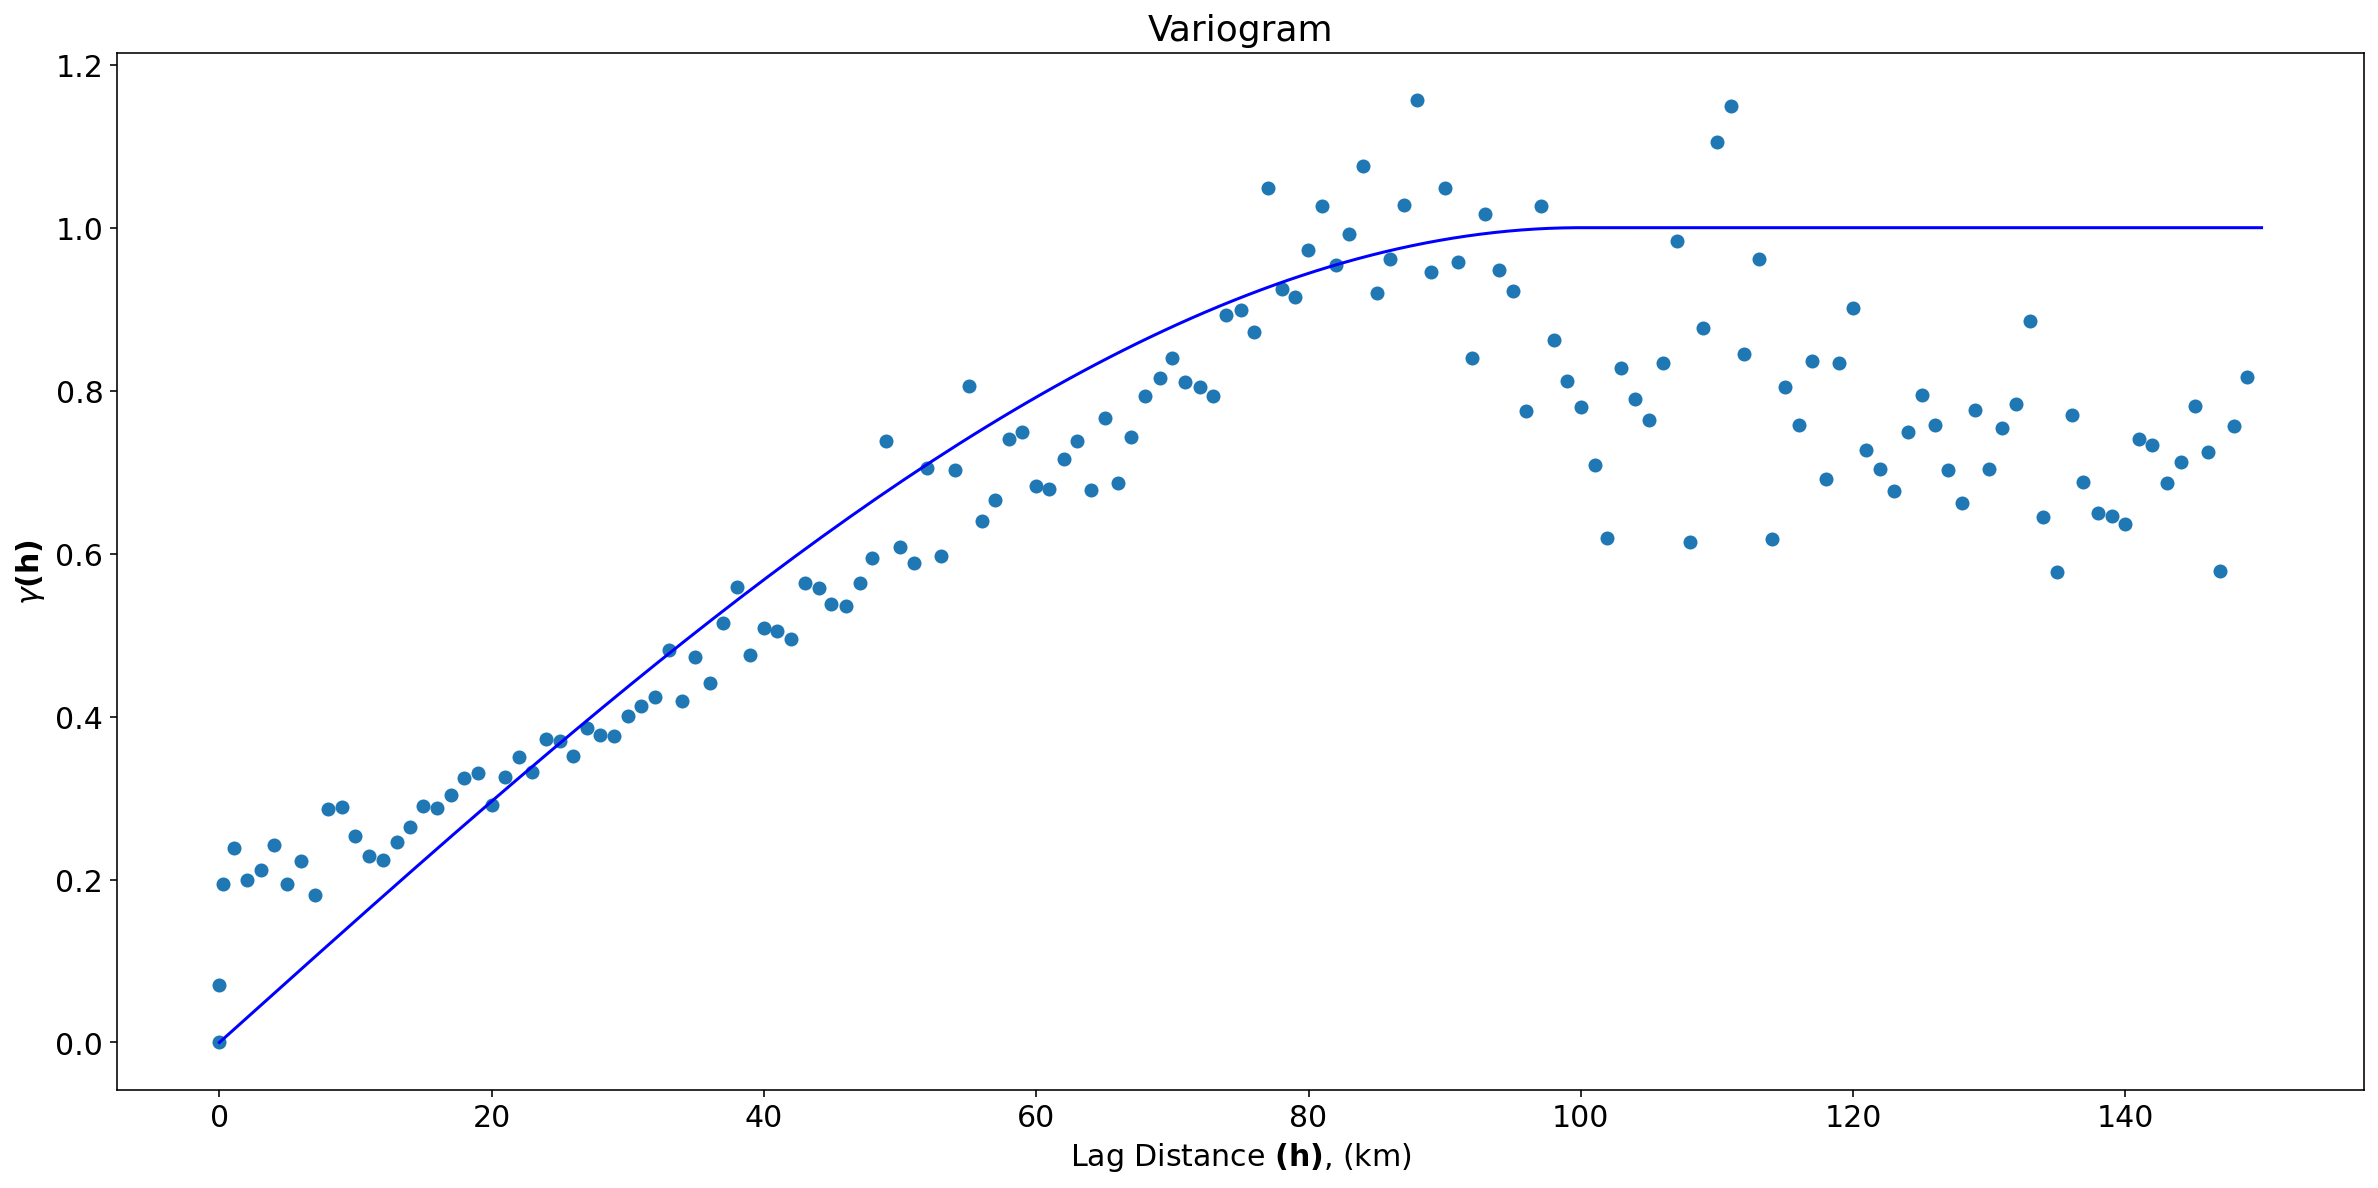

In [18]:
Azimuth = 0 # azimuthal direction of major axis
nug = 0 # nugget
nstruct = 1 # variogram structures
vtype = [1] # exponential type (1 = spherical, 2 = exponential, 3 = Gaussian)
cc = [1] # contribution for each structure. nugget + cc = 1
a_max = [100] # major range for each structure
a_min = [100] # minor range for each structure

vario = [Azimuth, nug, nstruct, vtype, cc, a_max, a_min] # save variogram parameters as a list


model = gs.axis_var(np.linspace(0,nlag,nlag)*lag_dist, 
                 nug, nstruct, cc, vtype, a_max)

plt.figure(figsize = [13,6])
plt.scatter(lag,gamma)
plt.plot(np.linspace(0,nlag,nlag)*lag_dist,model,'-',color = 'blue',label = 'Modeled, major axis')
plt.xlabel(r'Lag Distance $\bf(h)$, (km)')
plt.ylabel(r'$\gamma \bf(h)$')
plt.title('Variogram')

plt.subplots_adjust(left=0.0, bottom=0.0, right=1.2, top=1.2, wspace=0.1, hspace=0.2) # adjust the plot size
plt.show()

## Kriging with different resolutions

The idea of kriging is to estimate the unobserved location value $Z(x_0)$ with the linear combination of the observed data $Z(x_1),...,Z(x_n)$ around $Z(x_0)$:

$$Z(x_0) = \sum_{i = 1}^n \lambda_i Z(x_i)$$

In this notebook, we won't cover the [mathematical details](https://link.springer.com/chapter/10.1007%2F978-3-319-15865-5_4#Sec3) of how to derive $\lambda_i$. But we know that closer points will give higher weights and far points will give lower weights. This spatial correlation has been already characterized in our previous variogram analysis. 





Here we choose the resolution of predictions: 5 km. We can change the resolution in kriging later for multi-resolution predictions. 

You can tweak the resolution parameters below to see interpolation results in different resolutions. Note that the finer the resolution you want, the longer the estimation will be. 


In [19]:
# Resolution (km)
resolution = 5

# Bounding box
minx = 545
maxx = 885
miny = 3884
maxy = 4494

# x, y range
x = np.arange(minx,maxx,resolution)
y = np.arange(miny,maxy,resolution)

xx,yy = np.meshgrid(x,y)
pred_grid_ = np.vstack([xx.reshape(-1),yy.reshape(-1)]).T

# find which grid is within the central valley polygon
point_sets = [Point(pred_grid_[i,0],pred_grid_[i,1]) for i in range(len(pred_grid_))]
in_valley_or_not = [central_valley_xy.contains(point) for point in point_sets]
in_valley_or_not = [not value for value in in_valley_or_not]

In [20]:
# Kriging
k = 10 # number of neighboring data points used to estimate a given point 
est_SK, var_SK = gs.skrige(pred_grid_, groundwater, 'x', 'y', 'GWE_ns', k, vario) # estimation and variance

100%|██████████| 8296/8296 [00:18<00:00, 446.43it/s]


Back transformation: from normal score to the original distribution

In [21]:
# Back transformation
# create dataframes for back transform function
std_SK = np.sqrt(var_SK)
gwe_std = pd.DataFrame(std_SK, columns = ['std'])
gwe_krige = pd.DataFrame(est_SK, columns = ['pred'])

# transformation parameters
vr = tvgwe
vrg = tnsgwe
ltail = 1
utail = 1
zmin = -4
zmax = 4
ltpar = -1000
utpar = 1000

# transformation
pred_trans = geostats.backtr(gwe_krige,'pred',vr,vrg,zmin,zmax,ltail,ltpar,utail,utpar)
std_trans = geostats.backtr(gwe_std,'std',vr,vrg,zmin,zmax,ltail,ltpar,utail,utpar)

pred_trans[in_valley_or_not] = np.nan
std_trans[in_valley_or_not] = np.nan
var_trans = std_trans*std_trans

(-0.5, 67.5, -0.5, 121.5)

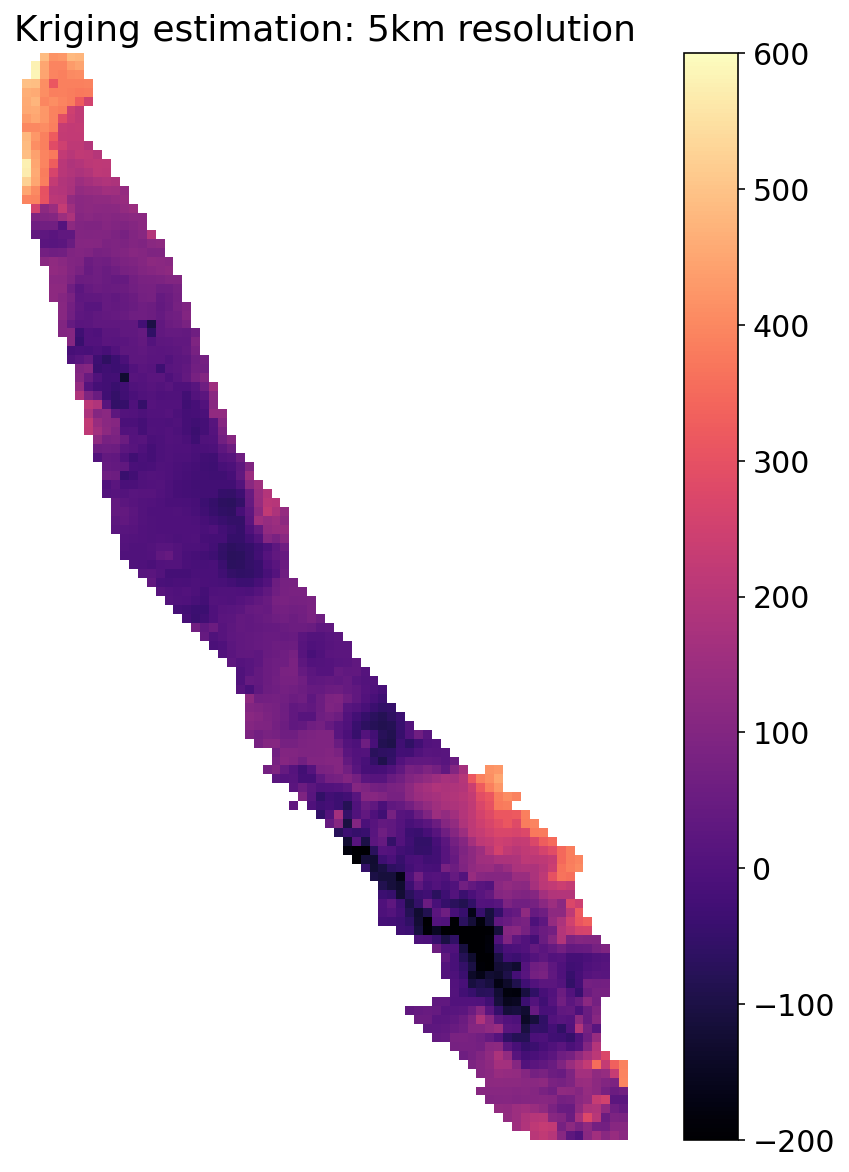

In [22]:
fig, ax = plt.subplots(figsize=[10,10])
plt.imshow(pred_trans.reshape(xx.shape),origin = 'lower',cmap = 'magma',vmin = -200,vmax = 600)
plt.colorbar()
plt.title('Kriging estimation: '+str(resolution)+'km resolution')
plt.axis('off')

We now have a full and smooth map of groundwater level of central valley! The lowest groundwater level is in the southwest part of the central valley: Tulare basin. Tulare basin is the place where we have the most severe overpumping issue. 

# Uncertainty of spatial interpolation



In this last section, I wish to briefly cover the uncertainty of spatial interpolation using kriging. Kriging assumes the Gaussian distribution, hence apart from the mean (kriging estimation), we can also derive the kriging variance. 


(-0.5, 67.5, -0.5, 121.5)

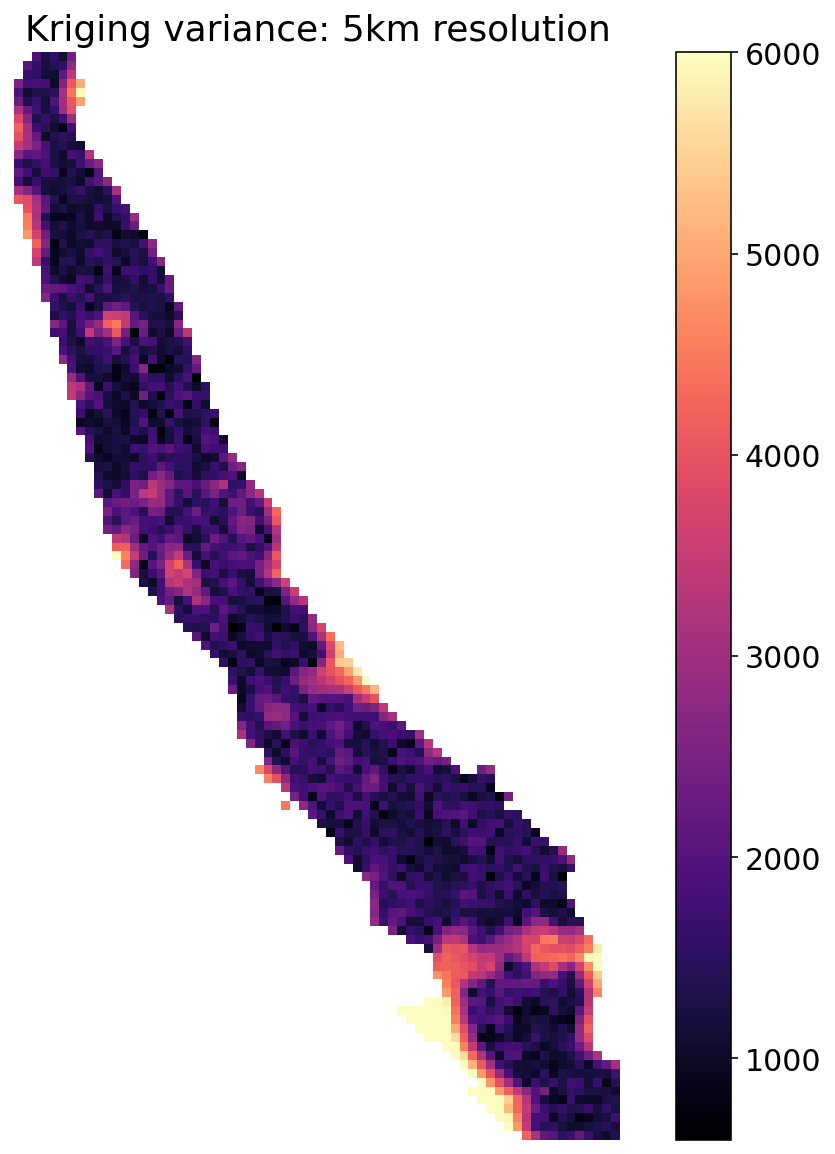

In [23]:
fig, ax = plt.subplots(figsize=[10,10])
plt.imshow(var_trans.reshape(xx.shape),origin = 'lower',cmap = 'magma',vmax = 6000)
plt.colorbar()
plt.title('Kriging variance: '+str(resolution)+'km resolution')
plt.axis('off')



As shown above, we are more certain about our kriging estimation when it is close to the data, and less certain when we do not have enough data. 


# Summary

1. We learned that the spatial correlation is the key in spatial data analysis.
2. We learned to visualize spatial data
3. We learned how to use kriging to do spatial interpolation and quantify the uncertainty of our spatial interpolation. 

Do you have any other spatial dataset? Bring your own dataset and try spatial interpolation! 

Also, let's chat more if you have any question on spatial data analysis! 